In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

#Prepare the data.
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from numpy import linalg as LA

dtype = torch.FloatTensor

images = np.load("./data/images.npy")
labels = np.load("./data/labels.npy")

images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))

images = images - images.mean()
images = images/images.std() 

train_seqs = images[0:40000]
val_seqs = images[40000:50000]

train_labels = labels[0:40000]
cv_labels = labels[40000:50000]

In [3]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
learning_rate = 0.01

class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
        

In [4]:
model = TooSimpleConvNN()

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [6]:
def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

In [7]:
def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

In [8]:
import random

#approx train accuracy() that extracts 1,000 random training
#instances, creates a single batch with all of these inputs, computes integer predictions
#for each example in the batch, and returns an accuracy by comparing these
#predictions to the ground-truth labels.

def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)
    return acc

#val accuracy() that creates a single batch with all validation
#examples, computes integer predictions for each example in the batch, and returns
#an accuracy by comparing these predictions to the ground-truth labels

def val_accuracy():
    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int) 
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)

    return acc

In [9]:
for m in model.children():
    m.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_accs, val_accs = [], []
batch_size = 300
for i in range(3000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.21  0.21
   100  0.67  0.70
   200  0.73  0.73
   300  0.77  0.76
   400  0.76  0.77
   500  0.77  0.76
   600  0.81  0.80
   700  0.79  0.79
   800  0.81  0.81
   900  0.83  0.81
  1000  0.81  0.82
  1100  0.83  0.83
  1200  0.82  0.82
  1300  0.85  0.86
  1400  0.83  0.83
  1500  0.85  0.86
  1600  0.84  0.84
  1700  0.85  0.83
  1800  0.87  0.86
  1900  0.83  0.84
  2000  0.83  0.85
  2100  0.86  0.83
  2200  0.88  0.84
  2300  0.87  0.87
  2400  0.84  0.86
  2500  0.84  0.85
  2600  0.87  0.87
  2700  0.86  0.84
  2800  0.83  0.86
  2900  0.87  0.85


max_train accuracy:  0.877
max_val accuracy:  0.869


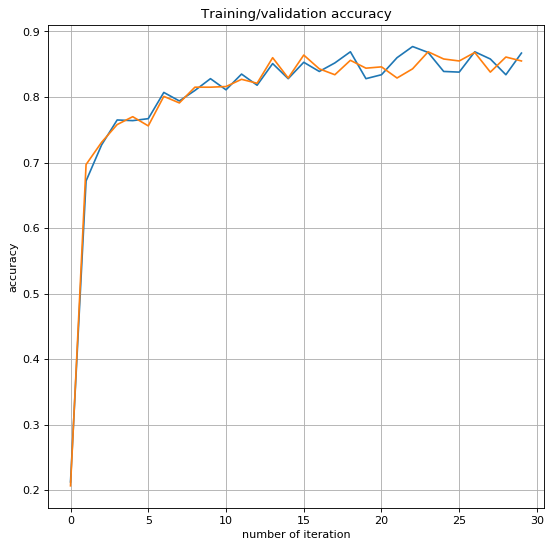

In [10]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# Simple Conv nn with stride 1

In [11]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
learning_rate = 0.01

class SimpleConvNNStride1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
        

model = SimpleConvNNStride1()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

import random
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)
    return acc

def val_accuracy():
    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int) 
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)

    return acc

for m in model.children():
    m.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_accs, val_accs = [], []
batch_size = 300
for i in range(10000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.20  0.20
   100  0.69  0.68
   200  0.71  0.73
   300  0.72  0.76
   400  0.77  0.80
   500  0.76  0.77
   600  0.81  0.79
   700  0.81  0.81
   800  0.77  0.80
   900  0.79  0.81
  1000  0.80  0.83
  1100  0.80  0.82
  1200  0.83  0.82
  1300  0.83  0.83
  1400  0.83  0.84
  1500  0.81  0.79
  1600  0.79  0.78
  1700  0.87  0.85
  1800  0.85  0.83
  1900  0.84  0.83
  2000  0.85  0.86
  2100  0.84  0.85
  2200  0.84  0.86
  2300  0.86  0.84
  2400  0.83  0.84
  2500  0.85  0.84
  2600  0.85  0.86
  2700  0.88  0.85
  2800  0.83  0.83
  2900  0.87  0.84
  3000  0.86  0.85
  3100  0.85  0.83
  3200  0.87  0.86
  3300  0.87  0.85
  3400  0.86  0.87
  3500  0.85  0.88
  3600  0.85  0.84
  3700  0.85  0.87
  3800  0.87  0.87
  3900  0.86  0.87
  4000  0.88  0.88
  4100  0.87  0.88
  4200  0.88  0.89
  4300  0.85  0.87
  4400  0.87  0.87
  4500  0.85  0.87
  4600  0.86  0.85
  4700  0.88  0.89
  4800  0.87  0.87
  4900  0.84  0.85
  5000  0.85  0.88
  5100  0.88  0.88
  5200  0.88

max_train accuracy:  0.913
max_val accuracy:  0.91


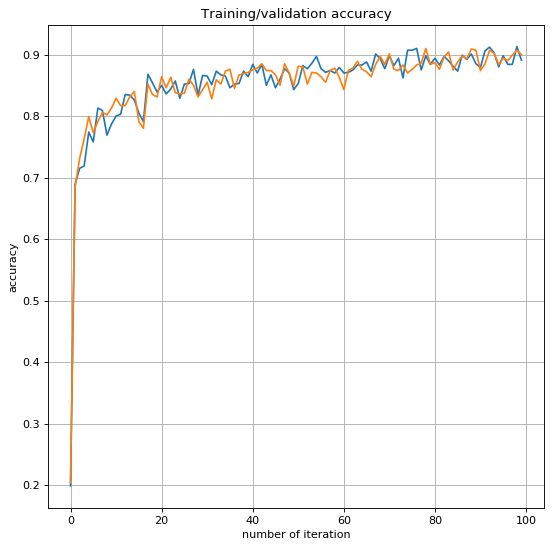

In [12]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# Conv experiment: Change stride to 2

In [13]:
for m in model.children():
    m.reset_parameters()
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
#learning_rate = 0.01

class SimpleConvNNStride2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=2)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
        

model = SimpleConvNNStride2()

optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

import random
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)
    return acc

def val_accuracy():
    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int) 
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)

    return acc

for m in model.children():
    m.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_accs, val_accs = [], []
batch_size = 200
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))



     0  0.23  0.25
   100  0.72  0.72
   200  0.77  0.77
   300  0.79  0.79
   400  0.80  0.78
   500  0.79  0.80
   600  0.82  0.84
   700  0.84  0.85
   800  0.86  0.84
   900  0.85  0.85
  1000  0.87  0.83
  1100  0.85  0.87
  1200  0.86  0.85
  1300  0.87  0.86
  1400  0.85  0.84
  1500  0.84  0.81
  1600  0.88  0.87
  1700  0.89  0.86
  1800  0.87  0.87
  1900  0.89  0.88
  2000  0.88  0.86
  2100  0.87  0.86
  2200  0.87  0.86
  2300  0.88  0.87
  2400  0.86  0.86
  2500  0.89  0.88
  2600  0.86  0.86
  2700  0.89  0.90
  2800  0.88  0.88
  2900  0.88  0.84
  3000  0.87  0.87
  3100  0.91  0.89
  3200  0.88  0.87
  3300  0.90  0.87
  3400  0.89  0.88
  3500  0.88  0.89
  3600  0.88  0.89
  3700  0.91  0.88
  3800  0.89  0.89
  3900  0.89  0.88
  4000  0.90  0.88
  4100  0.89  0.90
  4200  0.90  0.88
  4300  0.90  0.87
  4400  0.88  0.88
  4500  0.88  0.87
  4600  0.88  0.88
  4700  0.91  0.87
  4800  0.89  0.88
  4900  0.89  0.88


max_train accuracy:  0.91
max_val accuracy:  0.897


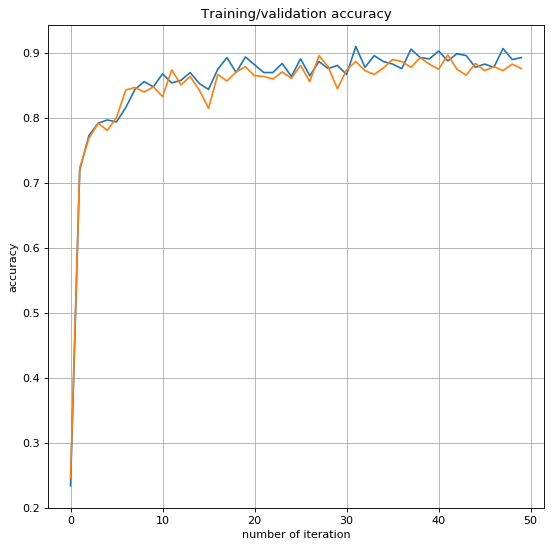

In [14]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# Results for Experiments:

Highest Accuracy achieved : 92%

Settings: 
    1. Stride in conv layers = 1
    2. Learning rate = 0.005
    3. batch size = 300
    4. epochs = 10,000
    
Overfitting is seen when trained the model with stride 2 in all convolutional layers.

Approach to Maximising the performance:

We plan to maximise the performance by experimenting with:

1. Using a combination of convolution, pooling and relu units in each layers.
2. Using more than 2 layers with different combination of conv, pooling
3. Adding dropout before max pooling layers.
4. Adjusting the strides to 1 in all layers.
5. Adding a fully connected layers in the end.
